In [1]:
import sys
sys.path.append('..')  # To find camelid
import os
from os.path import join as pjoin
import csv

import pandas as pd
from pandas import DataFrame, Series
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from sqlalchemy import create_engine
from sqlalchemy.sql import text

from camelid.hypertext import cids_to_html

OUT_PATH = pjoin(os.getenv('CAMELID_HOME'), 'rdkit-testing', 'results')

In [2]:
conn = create_engine('postgresql://akokai@localhost/chmdata')

# Example searches

Lazy coding approach:
- I mostly (but not always) use the variables `cmd` (SQL query), `where` (conditional clause), and `res` (result) as one-time, throw-away objects.
- For further inspection of some large and complex result sets, I am outputting HTML files that use PubChem molecular structure graphics, since they're better than RDKit for organometallic structures.

## Search for dibenzodioxins

Using the canonical SMILES for dibenzodioxin as a search query, the results are the expected set of dioxin derivatives with 3+ rings.

In [3]:
cmd = text('''select cid, inchi, molecule from cpds where molecule @> 'C1=CC=C2C(=C1)OC3=CC=CC=C3O2';''')
ddx = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(ddx), 'results')
ddx.head(10)

203 results


,cid,inchi,molecule
0,9216,InChI=1S/C12H8O2/c1-2-6-10-9(5-1)13-11-7-3-4-8...,c1ccc2c(c1)Oc1ccccc1O2
1,36613,InChI=1S/C12H6Cl2O2/c13-7-1-3-9-11(5-7)16-10-4...,Clc1ccc2c(c1)Oc1ccc(Cl)cc1O2
2,29575,InChI=1S/C12H2Cl6O2/c13-3-1-5-11(9(17)7(3)15)2...,Clc1cc2c(c(Cl)c1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
3,15625,InChI=1S/C12H4Cl4O2/c13-5-1-9-10(2-6(5)14)18-1...,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
4,42540,InChI=1S/C12H2Cl6O2/c13-3-1-5-11(9(17)7(3)15)2...,Clc1cc2c(c(Cl)c1Cl)Oc1cc(Cl)c(Cl)c(Cl)c1O2
5,18636,InChI=1S/C12Cl8O2/c13-1-2(14)6(18)10-9(5(1)17)...,Clc1c(Cl)c(Cl)c2c(c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)...
6,38251,InChI=1S/C12H2Cl6O2/c13-3-1-5-6(2-4(3)14)20-12...,Clc1cc2c(cc1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
7,38439,InChI=1S/C12H3Cl5O2/c13-4-1-7-8(2-5(4)14)19-12...,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
8,37270,InChI=1S/C12HCl7O2/c13-2-1-3-10(7(17)4(2)14)21...,Clc1cc2c(c(Cl)c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
9,86291,InChI=1S/C12H4Br4O2/c13-5-1-7(15)11-9(3-5)17-1...,Brc1cc(Br)c2c(c1)Oc1cc(Br)cc(Br)c1O2


### Draw results into a grid

Apparently any number of molecules can be drawn in a grid, within a single SVG image.

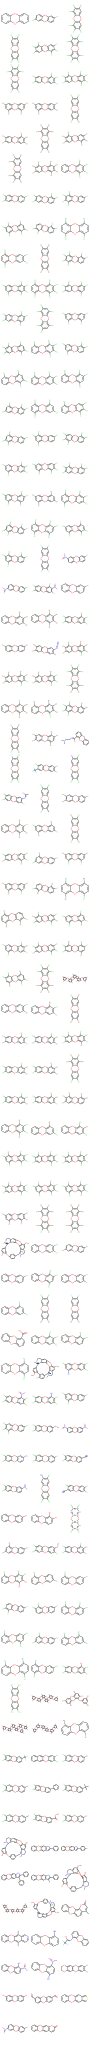

In [4]:
ddx['mol'] = ddx.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(ddx.loc[:, 'mol'])

## Search for dioxin-like compounds

Simply searching for superstructures of 1,4-dioxin (SMILES `C1=COC=CO1`) fails to produce the expected results if you specify double bonds between the C atoms, since that is not where the C=C bonds of all dioxin derivatives will necessarily be drawn, if they are fused to other aromatic rings.

3 results


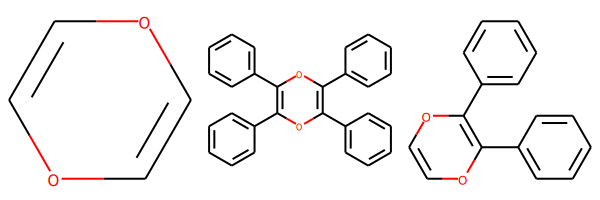

In [5]:
cmd = text('''select cid, inchi, molecule from cpds where molecule @> 'C1=COC=CO1';''')
res = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(res), 'results')
res['mol'] = res.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(res.loc[:, 'mol'])

If we drop the double bonds and instead use SMARTS to specify that those C atoms are "aromatic", you get a similar set of results to the dibenzodioxin example above, except some of the outer rings have heteroatoms.

In [6]:
cmd = text('''select cid, inchi, molecule from cpds where molecule @> 'c1cOccO1'::qmol;''')
dxar = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(dxar), 'results')
dxar.head(10)

207 results


,cid,inchi,molecule
0,9216,InChI=1S/C12H8O2/c1-2-6-10-9(5-1)13-11-7-3-4-8...,c1ccc2c(c1)Oc1ccccc1O2
1,36613,InChI=1S/C12H6Cl2O2/c13-7-1-3-9-11(5-7)16-10-4...,Clc1ccc2c(c1)Oc1ccc(Cl)cc1O2
2,29575,InChI=1S/C12H2Cl6O2/c13-3-1-5-11(9(17)7(3)15)2...,Clc1cc2c(c(Cl)c1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
3,15625,InChI=1S/C12H4Cl4O2/c13-5-1-9-10(2-6(5)14)18-1...,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
4,42540,InChI=1S/C12H2Cl6O2/c13-3-1-5-11(9(17)7(3)15)2...,Clc1cc2c(c(Cl)c1Cl)Oc1cc(Cl)c(Cl)c(Cl)c1O2
5,18636,InChI=1S/C12Cl8O2/c13-1-2(14)6(18)10-9(5(1)17)...,Clc1c(Cl)c(Cl)c2c(c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)...
6,38251,InChI=1S/C12H2Cl6O2/c13-3-1-5-6(2-4(3)14)20-12...,Clc1cc2c(cc1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
7,38439,InChI=1S/C12H3Cl5O2/c13-4-1-7-8(2-5(4)14)19-12...,Clc1cc2c(cc1Cl)Oc1c(cc(Cl)c(Cl)c1Cl)O2
8,37270,InChI=1S/C12HCl7O2/c13-2-1-3-10(7(17)4(2)14)21...,Clc1cc2c(c(Cl)c1Cl)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
9,86291,InChI=1S/C12H4Br4O2/c13-5-1-7(15)11-9(3-5)17-1...,Brc1cc(Br)c2c(c1)Oc1cc(Br)cc(Br)c1O2


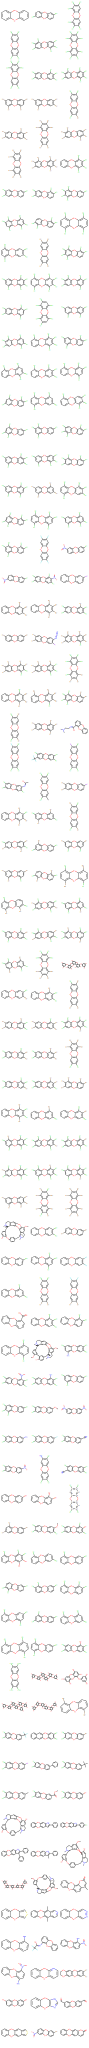

In [7]:
dxar['mol'] = dxar.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(dxar.loc[:, 'mol'])

Molecules returned by SMARTS "aromatic" query, that are not dibenzodioxins:


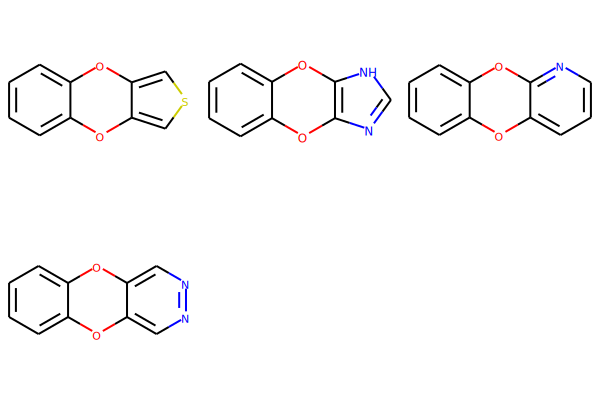

In [8]:
ddx_set = set(ddx.cid)
dxar_set = set(dxar.cid)

# Maybe the the aromatic-C-SMARTS results are a superset of dibenzodioxins?
if dxar_set >= ddx_set:
    print('Molecules returned by SMARTS "aromatic" query, that are not dibenzodioxins:')

diff = dxar_set - ddx_set
df = dxar.set_index('cid').loc[list(diff)]
Draw.MolsToGridImage(df.loc[:, 'mol'])

## Search for phthalates

Using a SMARTS query so that we can specify that there should be no more substituents around the benzene ring.

In [9]:
cmd = text('''select cid, inchi, molecule from cpds where molecule @> 'COC(=O)c1[cH][cH][cH][cH]c1C(=O)OC'::qmol;''')
res = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(res), 'results')
res.head(10)

240 results


,cid,inchi,molecule
0,2347,InChI=1S/C19H20O4/c1-2-3-13-22-18(20)16-11-7-8...,CCCCOC(=O)c1ccccc1C(=O)OCc1ccccc1
1,8560,InChI=1S/C14H14O4/c1-3-9-17-13(15)11-7-5-6-8-1...,C=CCOC(=O)c1ccccc1C(=O)OCC=C
2,8343,InChI=1S/C24H38O4/c1-5-9-13-19(7-3)17-27-23(25...,CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC
3,5171383,InChI=1S/C28H34O10/c29-15-5-7-17-35-25(31)21-1...,O=C(OCCCCO)c1ccccc1C(=O)OCCCCOC(=O)c1ccccc1C(=...
4,6781,InChI=1S/C12H14O4/c1-3-15-11(13)9-7-5-6-8-10(9...,CCOC(=O)c1ccccc1C(=O)OCC
5,3026,InChI=1S/C16H22O4/c1-3-5-11-19-15(17)13-9-7-8-...,CCCCOC(=O)c1ccccc1C(=O)OCCCC
6,8346,InChI=1S/C24H38O4/c1-3-5-7-9-11-15-19-27-23(25...,CCCCCCCCOC(=O)c1ccccc1C(=O)OCCCCCCCC
7,8554,InChI=1S/C10H10O4/c1-13-9(11)7-5-3-4-6-8(7)10(...,COC(=O)c1ccccc1C(=O)OC
8,6782,InChI=1S/C16H22O4/c1-11(2)9-19-15(17)13-7-5-6-...,CC(C)COC(=O)c1ccccc1C(=O)OCC(C)C
9,6819,InChI=1S/C18H24O6/c1-3-5-11-22-16(19)13-24-18(...,CCCCOC(=O)COC(=O)c1ccccc1C(=O)OCCCC


Draw the first 10 results...

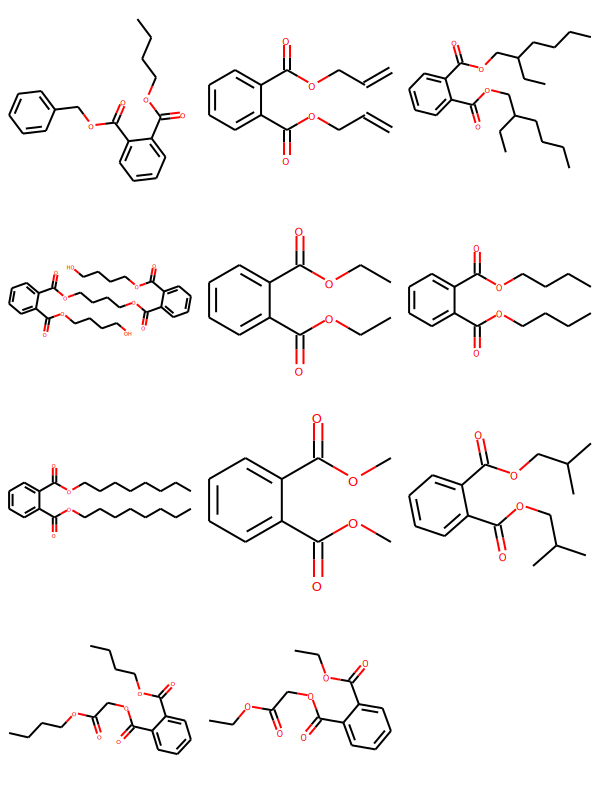

In [10]:
res['mol'] = res.inchi.apply(Chem.MolFromInchi)
Draw.MolsToGridImage(res.loc[:10, 'mol'])

## Antimony compounds, inorganic

Here's where it gets interesting.

### SMARTS query molecule

This is for the interpretation where "inorganic" means "Sb is not bound to C."

In [3]:
where = "molecule @> '[Sb].[!C;!c]'::qmol"  # Remember this SQL query clause.
cmd = text("select cid, inchi, molecule from cpds where {};".format(where))
sbin_smarts = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(sbin_smarts), 'results')
sbin_smarts.head(10)

359 results


,cid,inchi,molecule
0,150258,InChI=1S/C3H9O.6ClH.Sb/c1-4(2)3;;;;;;;/h1-3H3;...,C[O+](C)C.[Cl-].[Cl-].[Cl-].[Cl-].[Cl-].[Cl-]....
1,160146,InChI=1S/3C10H20O2S.Sb/c3*1-9(2)6-4-3-5-7-12-1...,CC(C)CCCCCOC(=O)C[S-].CC(C)CCCCCOC(=O)C[S-].CC...
2,16689752,InChI=1S/6S.4Sb,[S].[S].[S].[S].[S].[S].[Sb].[Sb].[Sb].[Sb]
3,64953,InChI=1S/C7H17NO5.H2O.2O.Sb/c1-8-2-4(10)6(12)7...,CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.[OH-].[...
4,6336886,InChI=1S/Sb.Zn,[Sb].[Zn]
5,16683083,InChI=1S/5S.2Sb,[S].[S].[S].[S].[S].[Sb].[Sb]
6,14813,InChI=1S/5O.2Sb,[O].[O].[O].[O].[O].[Sb].[Sb]
7,15238731,InChI=1S/4K.7O.2Sb/q4*+1;;;;4*-1;;,[K+].[K+].[K+].[K+].[O-].[O-].[O-].[O-].[O].[O...
8,6336873,InChI=1S/3Cd.2Sb,[Cd].[Cd].[Cd].[Sb].[Sb]
9,83753,InChI=1S/HI.S.Sb/h1H;;/q;;+1/p-1,[I-].[S].[Sb+]


Since the minimal-effort RDKit drawings are not very good for inorganic compounds, let's outsource this to PubChem for images. The results will not be viewable in this notebook, you need to load the resulting HTML file.

In [4]:
# Output to HTML, share the file...
cids_to_html(sbin_smarts['cid'],
             pjoin(OUT_PATH, 'Sb-inorganic-SMARTS.html'),
             where)  # ...including the query clause used to retrieve these results.

### SQL `and not` query

This is for the alternative interpretation where "inorganic" means "there are no organic components in the molecule."

In [5]:
where = "molecule @> '[Sb]' and not molecule @> 'C'"
cmd = text("select cid, inchi, molecule from cpds where {};".format(where))
sbin_sql = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(sbin_sql), 'results')
cids_to_html(sbin_sql['cid'], pjoin(OUT_PATH, 'Sb-inorganic-SQL.html'), where)
sbin_sql.head(10)

156 results


,cid,inchi,molecule
0,16689752,InChI=1S/6S.4Sb,[S].[S].[S].[S].[S].[S].[Sb].[Sb].[Sb].[Sb]
1,6336886,InChI=1S/Sb.Zn,[Sb].[Zn]
2,16683083,InChI=1S/5S.2Sb,[S].[S].[S].[S].[S].[Sb].[Sb]
3,14813,InChI=1S/5O.2Sb,[O].[O].[O].[O].[O].[Sb].[Sb]
4,15238731,InChI=1S/4K.7O.2Sb/q4*+1;;;;4*-1;;,[K+].[K+].[K+].[K+].[O-].[O-].[O-].[O-].[O].[O...
5,6336873,InChI=1S/3Cd.2Sb,[Cd].[Cd].[Cd].[Sb].[Sb]
6,6335314,InChI=1S/Sb/i1+5,[127Sb]
7,6335317,InChI=1S/Sb/i1+3,[125Sb]
8,117654,InChI=1S/P.Sb,[P].[Sb]
9,6337169,InChI=1S/2Sb.3Sr,[Sb].[Sb].[Sr].[Sr].[Sr]


### Compare the two result sets

In [8]:
sbin_smarts_set = set(sbin_smarts.cid)
sbin_sql_set = set(sbin_sql.cid)

print('SQL result set is a subset of SMARTS result set:', sbin_smarts_set >= sbin_sql_set)

diff1 = sbin_smarts_set - sbin_sql_set
print(len(diff1), 'compounds returned by SMARTS query but not the SQL query.')
cids_to_html(sorted(diff1), pjoin(OUT_PATH, 'Sb-inorg-diff-SMARTS-SQL.html'),
             '(Sb inorg SMARTS) - (Sb inorg SQL)')

diff2 = sbin_sql_set - sbin_smarts_set
print(len(diff2), 'compounds returned by the SQL set but not the SMARTS query.')
cids_to_html(sorted(diff2), pjoin(OUT_PATH, 'Sb-inorg-diff-SQL-SMARTS.html'),
             '(Sb inorg SQL) - (Sb inorg SMARTS)')

SQL result set is a subset of SMARTS result set: False
209 compounds returned by SMARTS query but not the SQL query.
6 compounds returned by the SQL set but not the SMARTS query.


## Antimony compounds, organic

### SMILES substructure

The query used in PubChem was `[Sb]C` (SMILES). In this case, if we use that here, we get no results unless we include a period, `[Sb].C` to indicate 'ligand' type relationship.
- But then, we need to check if these do actually contain C ligands (it appears that most of them do).
- Or, another interpretation would be that any compound containing organic components along with Sb should be included. That might need to be a different query.

In [9]:
where = "molecule @> '[Sb].C'"
cmd = text("select cid, inchi, molecule from cpds where {};".format(where))
sbc_smiles = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(sbc_smiles), 'results')
cids_to_html(sbc_smiles['cid'], pjoin(OUT_PATH, 'Sb-organic-SMILES.html'), where)
sbc_smiles.head(10)

111 results


,cid,inchi,molecule
0,11662,InChI=1S/3C6H5.2ClH.Sb/c3*1-2-4-6-5-3-1;;;/h3*...,[Cl-].[Cl-].[Sb+2].[c]1ccccc1.[c]1ccccc1.[c]1c...
1,16683975,InChI=1S/4C6H5.O.2Sb/c4*1-2-4-6-5-3-1;;;/h4*1-...,[O].[Sb].[Sb].[c]1ccccc1.[c]1ccccc1.[c]1ccccc1...
2,97653,InChI=1S/3CH3.2ClH.Sb/h3*1H3;2*1H;/q;;;;;+2/p-2,[CH3].[CH3].[CH3].[Cl-].[Cl-].[Sb+2]
3,139379,InChI=1S/3CH3.2HI.Sb/h3*1H3;2*1H;/q;;;;;+2/p-2,[CH3].[CH3].[CH3].[I-].[I-].[Sb+2]
4,139380,InChI=1S/3CH3.ClH.FH.Sb/h3*1H3;2*1H;/q;;;;;+2/p-2,[CH3].[CH3].[CH3].[Cl-].[F-].[Sb+2]
5,16683108,InChI=1S/C6H6N.CH3N2O2.H2O.O.Sb/c7-6-4-2-1-3-5...,N=C([O-])N[O-].NC1=CC=C=C[CH]1.O.[O].[Sb+2]
6,123354,InChI=1S/5CH3.Sb/h5*1H3;,[CH3].[CH3].[CH3].[CH3].[CH3].[Sb]
7,141126,InChI=1S/3CH3.2BrH.Sb/h3*1H3;2*1H;/q;;;;;+2/p-2,[Br-].[Br-].[CH3].[CH3].[CH3].[Sb+2]
8,77566,InChI=1S/3C6H5.S.Sb/c3*1-2-4-6-5-3-1;;/h3*1-5H;;,[S].[Sb].[c]1ccccc1.[c]1ccccc1.[c]1ccccc1
9,136267,InChI=1S/CF3.2CH3.Sb/c2-1(3)4;;;/h;2*1H3;,F[C](F)F.[CH3].[CH3].[Sb]


### SMARTS

Another approach, using what ought to be an equivalent SMARTS query, gives ~2x as many results.
Seems that only a couple of them lack direct C-Sb bonds though.

In [10]:
where = "molecule @> '[Sb].[C,c]'::qmol"
cmd = text("select cid, inchi, molecule from cpds where {};".format(where))
sbc_smarts = DataFrame(conn.execute(cmd).fetchall(), columns=['cid', 'inchi', 'molecule'])
print(len(sbc_smarts), 'results')
cids_to_html(sbc_smarts['cid'], pjoin(OUT_PATH, 'Sb-organic-SMARTS.html'), where)
sbc_smarts.head(10)

203 results


,cid,inchi,molecule
0,150258,InChI=1S/C3H9O.6ClH.Sb/c1-4(2)3;;;;;;;/h1-3H3;...,C[O+](C)C.[Cl-].[Cl-].[Cl-].[Cl-].[Cl-].[Cl-]....
1,160146,InChI=1S/3C10H20O2S.Sb/c3*1-9(2)6-4-3-5-7-12-1...,CC(C)CCCCCOC(=O)C[S-].CC(C)CCCCCOC(=O)C[S-].CC...
2,64953,InChI=1S/C7H17NO5.H2O.2O.Sb/c1-8-2-4(10)6(12)7...,CNC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO.[OH-].[...
3,75822,InChI=1S/2C6H5.ClH.Sb/c2*1-2-4-6-5-3-1;;/h2*1-...,[Cl-].[Sb+].[c]1ccccc1.[c]1ccccc1
4,16684303,InChI=1S/3C10H20O2S.Sb/c3*1-9(2)6-4-3-5-7-13-8...,CC(C)CCCCCSCC(=O)[O-].CC(C)CCCCCSCC(=O)[O-].CC...
5,11662,InChI=1S/3C6H5.2ClH.Sb/c3*1-2-4-6-5-3-1;;;/h3*...,[Cl-].[Cl-].[Sb+2].[c]1ccccc1.[c]1ccccc1.[c]1c...
6,16683975,InChI=1S/4C6H5.O.2Sb/c4*1-2-4-6-5-3-1;;;/h4*1-...,[O].[Sb].[Sb].[c]1ccccc1.[c]1ccccc1.[c]1ccccc1...
7,16684212,"InChI=1S/C12H11PS2.2C6H5.Sb/c14-13(15,11-7-3-1...",S=P([S-])(c1ccccc1)c1ccccc1.[Sb+].[c]1ccccc1.[...
8,3079796,"InChI=1S/C6H15O2PS2.2C6H5.Sb/c1-5(2)7-9(10,11)...",CC(C)OP(=S)([S-])OC(C)C.[Sb+3].[c-]1ccccc1.[c-...
9,16683992,"InChI=1S/3C2H4O2.O.Sb/c3*1-2(3)4;;/h3*1H3,(H,3...",CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[O].[Sb+3]


### Compare the two result sets

In [15]:
sbc_smiles_set = set(sbc_smiles.cid)
sbc_smarts_set = set(sbc_smarts.cid)

print('SMILES result set is a subset of SMARTS result set:', sbc_smiles_set <= sbc_smarts_set)

diff1 = sbc_smarts_set - sbc_smiles_set
print(len(diff1), 'compounds returned by SMARTS query but not the SMILES query.')
cids_to_html(sorted(diff1), pjoin(OUT_PATH, 'Sb-org-diff-SMARTS-SMILES.html'),
             '(Sb org SMARTS) - (Sb org SMILES)')

SMILES result set is a subset of SMARTS result set: True
92 compounds returned by SMARTS query but not the SMILES query.
